# Sentiment Classification 

## IMPORTS AND DATA

In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from string import punctuation

nltk.download('vader_lexicon')

#Need to mount google drive to be able to access pretrained GloVe data 
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


In [ ]:
#Read in the data we are working with from file 
df = pd.read_csv("../content/WomensClothingECommerceReviews.csv")

In [ ]:
#Removes rows with nulls in given columns 
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
    
#Drops redundent ID column
df.drop(df.columns[0], inplace=True, axis=1)

<ipython-input-3-2dc968968111>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df.columns[0], inplace=True, axis=1)


## DATA PREPROCESSING

In [ ]:
#Create an instance of SIA from nltk  
SIA = SentimentIntensityAnalyzer()

#Convert the text in the Review Text column to a string
df['Review Text']= df['Review Text'].astype(str)

#Create four new columns that have polarity scores for neutral, negative, and positive and an overall score
df['Polarity Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['pos'])

#Create a new Sentiment column that looks at polarity scores and assigns it either a positive, negative, or neutral assignment
df['Sentiment'] = ''
df.loc[df['Polarity Score'] > 0, 'Sentiment'] = 'Positive'
df.loc[df['Polarity Score'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity Score'] < 0, 'Sentiment'] = 'Negative'

## Word Embeddings

In [ ]:
#Create a series of product reviews and convert the text to a string then lowercase
reviews = df['Review Text'].astype(str).str.lower()

#Creates the features by converting np series to list
features = reviews.tolist()

In [ ]:
#Loop through the features by their index
for index in range(len(features)):

    #Get the charaters/words at each index of the features, check if it is a punctuation mark, if it isn't add it to the list, join that final list
    all_text = ''.join([character for character in features[index] if character not in punctuation])

    #Look at each review and split it base on the characters '\n', '\r'
    features[index] = re.split(r'\n|\r', all_text)

    #Look at each review, loop through the words in that review and add to list, join that list based on spaces
    features[index] = ' '.join([word for word in features[index]])

#Check the features to make sure we get what we want
features      

['absolutely wonderful  silky and sexy and comfortable',
 'love this dress  its sooo pretty  i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite  i bought a petite and am 58  i love the length on me hits just a little below the knee  would definitely be a true midi on someone who is truly petite',
 'i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper  it c',
 'i love love love this jumpsuit its fun flirty and fabulous every time i wear it i get nothing but great compliments',
 'this shirt is very flattering to al

In [ ]:
#Create an instance of a text tokenizer
t = Tokenizer()

#Tokenize all the words in each review (finds all the words that appear in the corpus and counts how often they appear)
t.fit_on_texts(features)

#Get the vocabulary size (how many unique words are there)
vocabulary_size = len(t.word_index) + 1

#Print the vocab size ()
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 19370


In [ ]:
#Looks at each word in each review and replaces it with its integer representation from word_index
encoded_features = t.texts_to_sequences(features)

#Create a max length variable that sets the max length for each review at 300 words
max_length = 300

#Perform post padding on the features matrix (post means padding is applied after each sequence)
padded_features = tf.keras.preprocessing.sequence.pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [ ]:
#Create a dictionary variable to store embeddings 
embeddings_index = dict()

#Open the pretrained GloVe data from google drive
with open('../content/drive/MyDrive/GloveEmbeddings/glove.6B.300d.txt') as file:

    #Read each line of the text data
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:

    #Split each line and return the word and its 300D vector
    word, vec = line.split(' ', 1)

    #Make each word a key, the value for each key is a np array of vector values
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')

#Print how many word vectors there are
print('Loaded {} word vectors.'.format(len(embeddings_index)))

#Create a 19370x300 matrix of zeros to store the embeddings
embedding_matrix = np.zeros((vocabulary_size, max_length))

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():
    
    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the vector to the matix at the appropriate index
        embedding_matrix[i] = embedding_vector

Loaded 399999 word vectors.


In [ ]:
#Create a list variable to store words
words = []

#Loop through the word_index and get the word and its index
for word, i in t.word_index.items():

    #Get the vector from embeddings_index dict
    embedding_vector = embeddings_index.get(word)

    #Check to make sure the vector is not empty
    if embedding_vector is not None:

        #Add the word to the words list
        words.append(word)

In [ ]:
#Print how many words we have seen
print('{} words covered.'.format(len(words)))

12272 words covered.


In [ ]:
#Find the percentage of words from the reviews that are in the vocab corpus
percentage = (len(words) / vocabulary_size) * 100.00

#The the percentage to the screen
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

63.35570469798658% of 19370 words were covered


## SENTIMENT CLASSIFICATION

In [ ]:
#Put the sentiment column into a np array and make it the labels
labels = np.array(df['Sentiment'])

#Loop through the labels and replace the strings 'Positive', 'Neutral', and 'Negative ' with the integers 2, 1, 0, respectively
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], np.int)

<ipython-input-13-f761efe04561>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels], np.int)


In [ ]:
#Create variables that are counts of of many positive, neutral, and negatives there are
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

#Creates a dataframe from those variables 
df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

In [ ]:
#Makes the lables appropriate for classification, ex: [2, 2, 1, 0] -> [[0,0,1], [0,0,1], [0,1,0], [1,0,0]]
labels = to_categorical(labels)

In [ ]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    # get the split size for training dataset
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    # get the split size for validation dataset
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [ ]:
#Create a train, test and validation set with the given parameters
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.60, validation_size=0.50)

In [ ]:
#Create an instance of a Sequential model
model = Sequential()

#Create a variable that stores the word embeddings that we created earlier
e = Embedding(vocabulary_size, max_length,
              weights=[embedding_matrix], input_length=max_length, trainable=False)

#Add the embeddings layer to the model
model.add(e)

#Add the Bidirectional RNN w/ LSTM layer to the model
  #LSTM will have an output in the 256 dim space 
  #Outputs of forward and backward RNN will be summed
model.add(Bidirectional(LSTM(256), merge_mode='sum'))

#Add a layer with a dropout rate of 0.5
model.add(Dropout(0.50))

#A a dense layer with dims 3 and softmax activation function
model.add(Dense(3, activation='softmax'))

#Compile the model and evaluate based with the provided arguements 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the model to the training data, we stat with 5 epochs and a batch size of 256 to match the dims of LSTM, verbose just outputs training info to user
model.fit(train_dataset[0], train_dataset[1], epochs=1, batch_size=256, verbose=1,
          validation_data=(validation_dataset[0], validation_dataset[1]))

#Evaluate the model based on the test data
score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

#Print the loss and accuracy to the screen
print('loss : {}, acc : {}'.format(score[0], score[1]))

142/142 [==============================] - 116s 811ms/step - loss: 0.2407 - accuracy: 0.9377
loss : 0.24068540334701538, acc : 0.9376932978630066


In [ ]:
#Create a variable that stores test predictions 
test_predictions = model.predict(test_dataset[0])

#Store indices of the maximum values along the axis.
test_predictions = np.argmax(test_predictions, axis=1)

#Create a list of class name
class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']

#Get the report of how the model performed
report = classification_report(np.argmax(test_dataset[1], axis=1), test_predictions, target_names=class_names)

142/142 [==============================] - 119s 828ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Print the report to the screen
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.00      0.00      0.00       257
 (1) Neutral class       0.00      0.00      0.00        25
(2) Positive class       0.94      1.00      0.97      4244

          accuracy                           0.94      4526
         macro avg       0.31      0.33      0.32      4526
      weighted avg       0.88      0.94      0.91      4526



In [ ]:
#Create a confusion matrix of the test predictions
conf_matrix = confusion_matrix(np.argmax(test_dataset[1], axis=1), test_predictions)

#Print the confusion matrix to the screen
print(conf_matrix)

[[   0    0  257]
 [   0    0   25]
 [   0    0 4244]]


<Axes: >

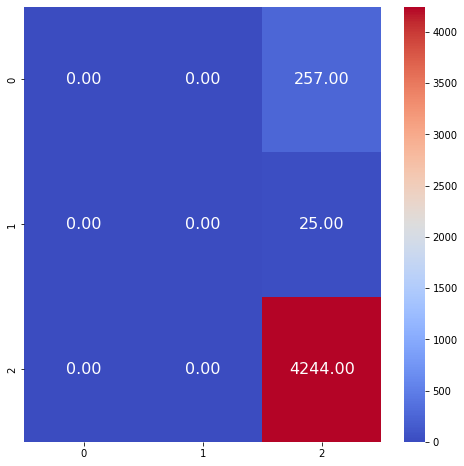

In [ ]:
#Set the figure size of the plot
plt.figure(figsize=(8, 8))

#Save the figure as a png
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)

#Create a heat map from the confusion matrix
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')